In [1]:
import pyms
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# Get crystal
crystal = pyms.structure.fromfile('Structures/SrTiO3.xyz',temperature_factor_units='ums')

gridshape = [256,256] # Grid size in pixels
tiling = [4,4] # Tile out grid to acceptable size
eV = 3e5 # Probe accelerating voltage in eV
app = 15 # Probe-forming aperture in mrad

# Set up thickness series
thicknesses = np.asarray([3.905,3.905*4])
# thicknesses = np.asarray([50,100, 200])

# Subslicing of crystal for multislice
nslices = int(np.ceil(crystal.unitcell[2]/2))
#nslices = 1
subslices = np.linspace(1.0/nslices,1.0,nslices)
nsubslices = len(subslices)

# # Number of frozen phonon passes
# nfph = 5
# Run absorptive calculation
nT=0
nfph=1

# Define detector inner and outer angles
# in order, a central bright-field detector, an annular 
# bright-field (ABF) detector 
detectors = [[0,app/2], [app/2,app]]

# If only 4D-STEM is requested set detectors to be None
# detectors = None

# 4D-STEM options:

# No 4D-STEM
FourDSTEM = False

# Probe defocus, an array can be provided for a defocus series
df = 0

# Define transitions on which cross-section calculations will be based
signal_list = [{"signal":"EELS","Z":8,"shell":"1s","E0":eV,"DeltaE":35,},{"signal":"EELS","Z":22,"shell":"2p","E0":eV,"DeltaE":35,}]
nsignals = len(signal_list)

# Option for more control over the device which performs the 
# calculation.
# GPU (CUDA) calculation
device = torch.device('cuda')
# CPU only calculation
# device = torch.device('cpu')

print('Max resolution permitted by the sample grid is {0} mrad'.format(pyms.max_grid_resolution(gridshape,np.asarray(tiling)*crystal.unitcell[:2],eV=eV)))

Max resolution permitted by the sample grid is 107.55435296085659 mrad


Frozen phonon iteration: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


elapsed time in seconds:  8.138468265533447


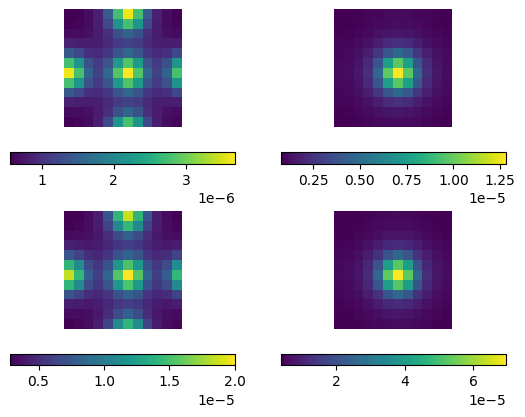

In [2]:
import time
t = time.time()

result2 = pyms.STEM_multislice(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    subslices=subslices,
    device_type=device,
    df=0,
    nfph=nfph,
    batch_size=1,
    FourD_STEM=FourDSTEM,
    PACBED=True,
    tiling=tiling,
    detector_ranges=detectors,
    signal_list=signal_list,
)

elapsed = time.time() - t
print('elapsed time in seconds: ',elapsed)

# TEMP FUDGE
# fig = plt.figure()
# ax = fig.add_subplot(1, 2, 1)
# imgplot = plt.imshow(np.squeeze(result2["STEM crosssection images"][0,:,:]))
# ax.set_axis_off()
# plt.colorbar(orientation='horizontal')
# ax = fig.add_subplot(1, 2, 2)
# imgplot = plt.imshow(np.squeeze(result2["STEM crosssection images"][1,:,:]))
# ax.set_axis_off()
# plt.colorbar(orientation='horizontal')
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(result2["STEM crosssection images"][0,0,:,:])
ax.set_axis_off()
plt.colorbar(orientation='horizontal')
ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(result2["STEM crosssection images"][1,0,:,:])
ax.set_axis_off()
plt.colorbar(orientation='horizontal')
ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(result2["STEM crosssection images"][0,1,:,:])
ax.set_axis_off()
plt.colorbar(orientation='horizontal')
ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(result2["STEM crosssection images"][1,1,:,:])
ax.set_axis_off()
plt.colorbar(orientation='horizontal')